### COSMOS

In [1]:
import torch
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
import utils.misc as misc
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        

In [2]:
import matplotlib.pyplot as plt
import random

def denormalize_image(normalized_image, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1) 
    std = torch.tensor(std).view(-1, 1, 1)   

    denormalized_image = normalized_image * std + mean

    denormalized_image = denormalized_image.clamp(0, 1)
    
    return denormalized_image

def visualize_results(preds, gts, dataset, k=5):
    indices = random.sample(range(len(preds)), k)
    
    for idx in indices:
        # Get data
        image, bboxes, caption1, caption2, label, bert_score = dataset[idx]
        pred_label = preds[idx]
        gt_label = gts[idx]

        # Plot image
        image = denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        plt.imshow(image.permute(1, 2, 0))  # if image is a tensor with shape (C, H, W)
        plt.axis('off')
        plt.title(f"Prediction: {'Out-of-context' if pred_label else 'In-context'} | "
                  f"Ground Truth: {'Out-of-context' if gt_label else 'In-context'} | "
                  f"{'✓' if pred_label == gt_label else '✗'}")
        plt.show()

        # Print captions
        print(f"Caption 1: {caption1}")
        print(f"Caption 2: {caption2}")
        print(f"BERT Score: {bert_score:.4f}")
        print("-" * 60)
        
        

In [10]:
from networks.cosmos import CosmosFullModel
from utils.data_loader import CosmosTestDataset


class CosmosTest:
    def __init__(self, load_path, device):
        self.device = device
        self.model = CosmosFullModel(300, device)
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)
        
        transform_full = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ]) 
        
        self.test_dataset = CosmosTestDataset(json_file="data/cosmos_anns_acm/cosmos_anns_acm/acm_anns/public_test_acm.json", \
            img_dir="data", transform_full=transform_full)

        self.dataloader = DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=1
        )
        
        
    def collate_fn(self, batch):
        images, bboxes, caption_match, caption_diff, label, bert_score  = zip(*batch)
        return list(images), list(bboxes), list(caption_match), list(caption_diff), list(label), list(bert_score)

    def get_prediction(self, caption1_scores, caption2_scores, bboxes, bert_score):
        caption1_bboxes = misc.top_bbox_from_scores(bboxes, caption1_scores)
        caption2_bboxes = misc.top_bbox_from_scores(bboxes, caption2_scores)
        bbox_overlap = misc.is_bbox_overlap(caption1_bboxes, caption2_bboxes, 0.5)
        if bbox_overlap:
            if bert_score >= 0.5:
                context = 0
            else:
                context = 1
            return context
        else:
            return 0
        
    def run_test(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for image, bboxes, caption1, caption2, label, bert_score in tqdm(self.dataloader, desc="Test Batch:"):
                object_embeddings, caption1_embeddings, caption2_embeddings = self.model(image, bboxes, caption1, caption2)
                caption1_scores = torch.einsum("bkd,bd->bk", object_embeddings, caption1_embeddings)
                caption2_scores = torch.einsum("bkd,bd->bk", object_embeddings, caption2_embeddings)
                bboxes = [bbox.tolist() for bbox in bboxes[0]]
                preds = self.get_prediction(caption1_scores[0], caption2_scores[0], bboxes, bert_score[0].item())
                labels = label[0].item()  # All match cases are positives
                
                all_preds.append(preds)
                all_labels.append(labels)
                
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        ap = average_precision_score(all_labels, all_preds)       
        
        tqdm.write(f"Test Metrics: Accuracy = {accuracy}, F1 Score = {f1}, Average Precision = {ap}") 
        
        return all_preds, all_labels

In [11]:
ct = CosmosTest(load_path="checkpoints/cosmos/save/maskrcnn_use_acc.torch", device="cuda:0")
all_preds, all_labels = ct.run_test()

/tmp/ipykernel_3751713/145043201.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)
Test Batch:: 100%|██████████| 1000/1000 [00:38<00:00,

Test Metrics: Accuracy = 0.768, F1 Score = 0.7827715355805244, Average Precision = 0.6972253521126761


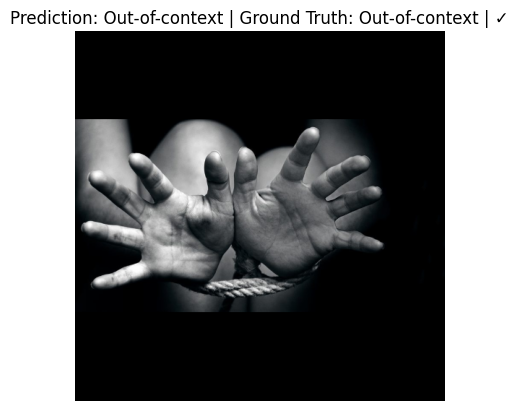

Caption 1: ORG ignored reports of a large child trafficking ring bust in GPE.
Caption 2: A black and white image of hands being tied together with rope.
BERT Score: -0.0394
------------------------------------------------------------


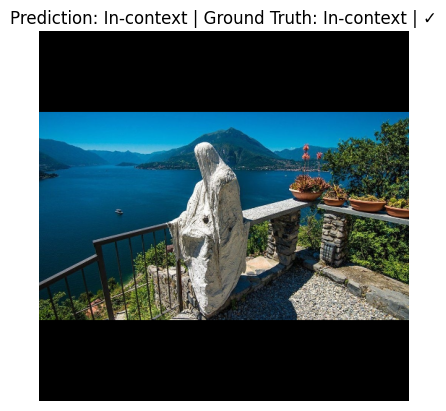

Caption 1: Plaster cast sculpture at ORG di ORG in GPE, GPE, Italy
Caption 2: Sculpture in GPE
BERT Score: 0.6364
------------------------------------------------------------


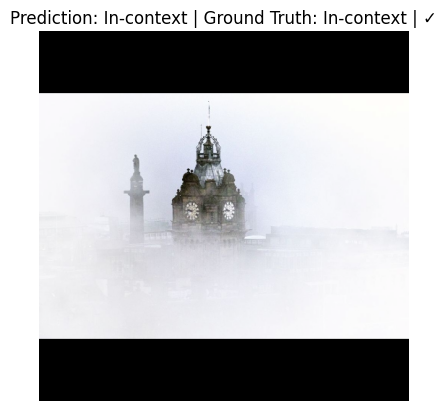

Caption 1: Fog surrounds ORG in GPE, as parts of the GPE saw some murky mornings at DATE.
Caption 2: Mist surrounds the Balmoral Clock on Princes Street in GPE
BERT Score: 0.6878
------------------------------------------------------------


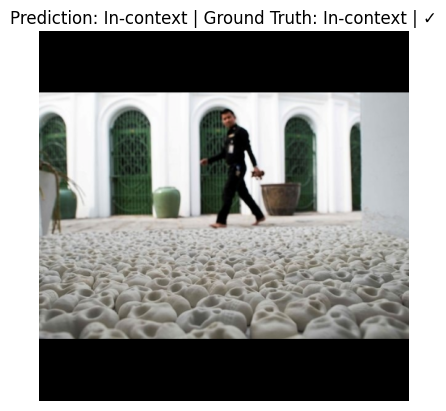

Caption 1: An art installation of tiny porcelain skulls by the NORP artist PERSON titled "WORK_OF_ART," at the Wat Prayurawongsawas temple in GPE.
Caption 2: A man walks past an art installation by NORP artist PERSON titled WORK_OF_ART,' part of ORG, at the ORG temple in GPE
BERT Score: 0.5056
------------------------------------------------------------


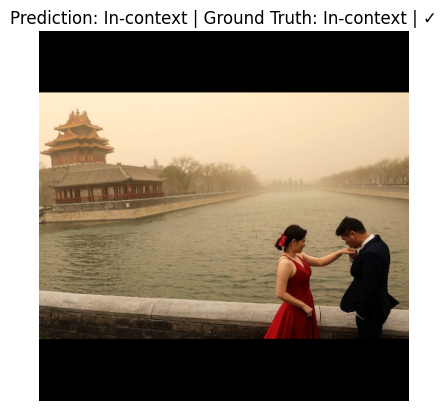

Caption 1: Despite the haze, CARDINAL couple went ahead with a wedding photoshoot near LOC.
Caption 2: A couple during a wedding photoshoot near GPE, GPE, on DATE
BERT Score: 0.5838
------------------------------------------------------------


In [12]:
visualize_results(all_preds, all_labels, ct.test_dataset)

In [7]:
from networks.ooc_models import OOCBasic
from utils.data_loader import CosmosTestDataset
from transformers import AutoTokenizer
from collections import defaultdict
import numpy as np

class OOCBasicTest:
    def __init__(self, load_path, device):
        self.device = device
        self.model = OOCBasic(img_model="vit_base_patch16_224", txt_model="sentence-transformers/all-mpnet-base-v2",
                 embed_dim=768, proj_dim=256, num_heads=8)
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)
        
        transform_full = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ]) 
        
        self.tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
        
        self.test_dataset = CosmosTestDataset(json_file="data/cosmos_anns_acm/cosmos_anns_acm/acm_anns/public_test_acm.json", \
            img_dir="data", transform_full=transform_full, size=224)

        self.dataloader = DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=1
        )
        
        
    def collate_fn(self, batch):
        images, bboxes, caption1, caption2, label, bert_score = zip(*batch)
        images = torch.stack(images, dim=0)
        
        caption1_tokens = self.tokenizer(
            caption1, return_tensors='pt', padding=True, truncation=True, max_length=32
        )
        caption2_tokens = self.tokenizer(
            caption2, return_tensors='pt', padding=True, truncation=True, max_length=32
        )

        return images, caption1_tokens, caption2_tokens, torch.stack(label, dim=0), torch.stack(bert_score, dim=0)

    def get_prediction(self, caption1_dist, caption2_dist, bert_score):
        if bert_score >= 0.5 and caption1_dist < 0.5 and caption2_dist < 0.5:
            return 0
        return 1
    
    def get_prediction_onsim(self, caption1_score, caption2_score, bert_score):
        if bert_score >= 0.5 and caption1_score > 0 and caption2_score > 0:
            return 0
        return 1
        
    def run_test(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        some_dict = defaultdict(list)
        with torch.no_grad():
            for image, caption1, caption2, label, bert_score in tqdm(self.dataloader, desc="Test Batch:"):
                image = image.to(self.device)
                caption1 = caption1.to(self.device)
                caption2 = caption2.to(self.device)
                object_embeddings, caption1_embeddings, caption2_embeddings = self.model(image, caption1, caption2)
                labels = label[0].item()
                caption1_sim = (object_embeddings * caption1_embeddings).sum(dim=1).cpu()
                caption2_sim = (object_embeddings * caption2_embeddings).sum(dim=1).cpu()
                preds = self.get_prediction_onsim(caption1_sim[0].item(), caption2_sim[0].item(), bert_score[0].item())
                all_preds.append(preds)
                all_labels.append(labels)
                 
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        ap = average_precision_score(all_labels, all_preds)       
        tqdm.write(f"Test Metrics: Accuracy = {accuracy}, F1 Score = {f1}, Average Precision = {ap}") 
        
        return all_preds, all_labels

In [8]:
ooc_basic_test = OOCBasicTest(load_path="checkpoints/ooc_basic/save/ooc_acc_bkup.torch", device="cuda:0")
all_preds, all_labels = ooc_basic_test.run_test()

/tmp/ipykernel_3751713/2696375752.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)
Test Batch:: 100%|██████████| 1000/1000 [00:33<00:0

Test Metrics: Accuracy = 0.745, F1 Score = 0.7696476964769647, Average Precision = 0.6719439868204282


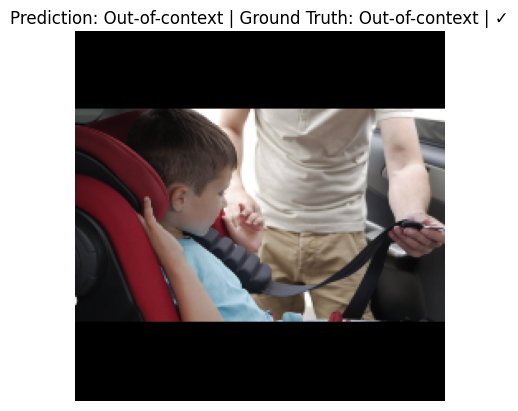

Caption 1: From DATE, it will be illegal to use a backless booster seat with a child DATE.
Caption 2: Parents who continue to put their children in booster cushions can continue to do so without breaking any laws in the GPE.
BERT Score: 0.2466
------------------------------------------------------------


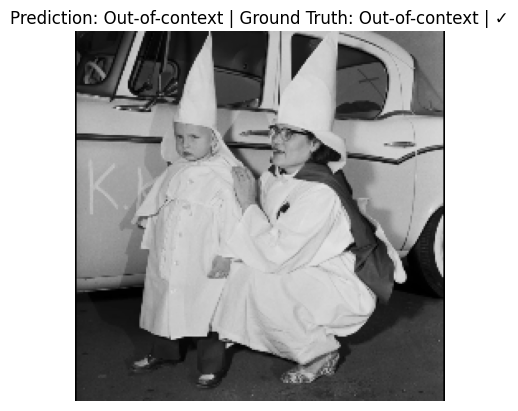

Caption 1: An image circulated on social media shows a young boy and a woman dressed in ORG (KKK) robes and hoods, with a caption identifying the pictured persons as now-Gov. PERSON of GPE and his mother
Caption 2: the creation date for this photograph as DATE. As PERSON was born in DATE, it is not temporally possible that he could be the young boy seen here.
BERT Score: 0.4233
------------------------------------------------------------


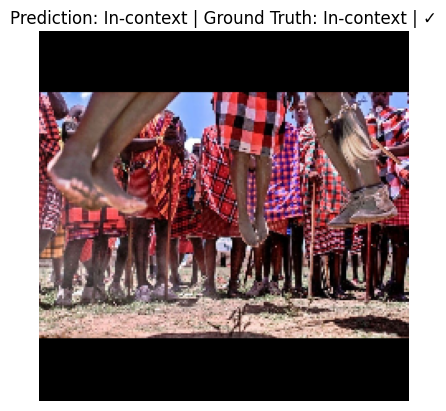

Caption 1: And on DATE in GPE's GPE, young PERSON men take part in initiation rites to become moran - the men who are traditionally the warrior class.
Caption 2: Men from the NORP PERSON tribe jump in unison during the rites.
BERT Score: 0.5022
------------------------------------------------------------


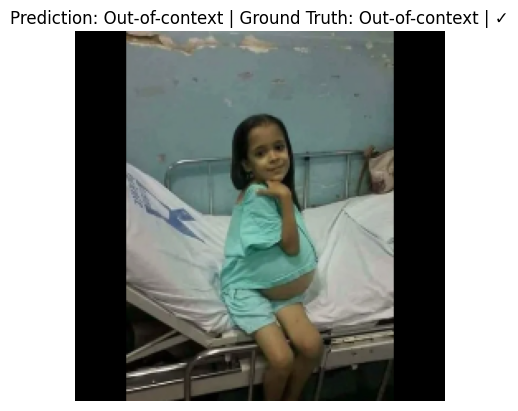

Caption 1: ORG showed a DATE girl who had been impregnated by a NORP man
Caption 2: This image does not show a pregnant child. This photograph was originally posted by the Garrafão do ORG page in DATE and shows a DATE girl named PERSON at a hospital in GPE, GPE.
BERT Score: 0.2058
------------------------------------------------------------


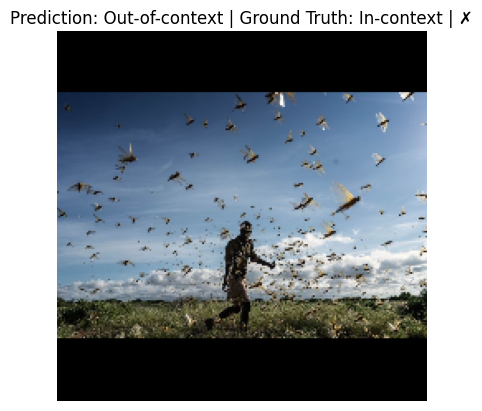

Caption 1: A man chases a swarm of desert locusts in GPE, GPE, on DATE
Caption 2: Locusts have been congregating in CARDINAL of NORP and NORP countries in DATE, in the worst swarms in DATE
BERT Score: 0.3492
------------------------------------------------------------


In [9]:
visualize_results(all_preds, all_labels, ooc_basic_test.test_dataset)